# Start dense and turn into Small World

In [26]:
import matplotlib
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np
import gymnasium as gym
import networkx as nx
from typing import Dict, Any, List, Tuple, Optional
from collections import deque
import random
import os
import tempfile
try:
    import imageio.v2 as imageio
except ImportError:
    try:
        import imageio
    except ImportError:
        imageio = None


def create_small_world_topology(input_dim: int, hidden_size: int, output_dim: int, 
                                k: int, p: float, seed: int) -> Tuple[nx.DiGraph, List[int], List[int]]:
    """
    Generate the small-world network topology as a single connected graph.

Args:
        input_dim: Number of input nodes
        hidden_size: Number of hidden nodes
        output_dim: Number of output nodes
        k: Number of neighbors in ring lattice (must be < hidden_size)
        p: Rewiring probability
        seed: Random seed for reproducibility
        
    Returns:
        Tuple of (topology graph, input_nodes list, output_nodes list)
    """
    # Bounds checking
    if k >= hidden_size:
        raise ValueError(f"k ({k}) must be less than hidden_size ({hidden_size})")
    if k < 2:
        raise ValueError(f"k ({k}) must be at least 2 for ring lattice")
    
    rng = np.random.RandomState(seed)
    total_nodes = input_dim + hidden_size + output_dim
    
    G = nx.DiGraph()
    G.add_nodes_from(range(total_nodes))
    
    hidden_start = input_dim
    hidden_end = hidden_start + hidden_size
    
    # Create initial ring lattice structure for hidden nodes (directed, acyclic)
    for i in range(hidden_start, hidden_end):
        # Only add edges to higher-indexed hidden nodes to maintain acyclicity
        for j in range(1, k // 2 + 1):
            target = hidden_start + ((i - hidden_start + j) % hidden_size)
            if target > i and target < hidden_end:  # Only add forward edges within hidden layer
                G.add_edge(i, target)
    
    # Rewire edges with probability p (maintaining acyclicity)
    for edge in list(G.edges()):
        if rng.random() < p:
            # Remove the edge
            G.remove_edge(*edge)
            # Add a new random edge (only to higher-indexed hidden nodes)
            # Error handling: ensure we can find a valid target
            if edge[0] + 1 < hidden_end:
                max_attempts = 100
                attempts = 0
                new_node = rng.randint(edge[0] + 1, hidden_end)
                while G.has_edge(edge[0], new_node) and attempts < max_attempts:
                    new_node = rng.randint(edge[0] + 1, hidden_end)
                    attempts += 1
                if attempts < max_attempts:
                    G.add_edge(edge[0], new_node)
                # If we can't find a valid edge, just skip rewiring for this edge
    
    # Add connections from input nodes to hidden nodes
    if input_dim is not None:
        for input_node in range(input_dim):
            for hidden_node in range(hidden_start, hidden_start + min(k, hidden_size)):
                G.add_edge(input_node, hidden_node)
    
    # Add connections from hidden nodes to output nodes
    if output_dim is not None:
        for output_node in range(hidden_end, total_nodes):
            for hidden_node in range(hidden_end - min(k, hidden_size), hidden_end):
                G.add_edge(hidden_node, output_node)
    
    # Ensure topology is a DAG
    if not nx.is_directed_acyclic_graph(G):
        raise ValueError("FFN requires a Directed Acyclic Graph (DAG) topology")
    
    input_nodes = list(range(input_dim))
    output_nodes = list(range(input_dim + hidden_size, input_dim + hidden_size + output_dim))
    
    return G, input_nodes, output_nodes



def create_dense_topology(input_dim: int, hidden_layers: List[int], output_dim: int, seed: int
                         ) -> Tuple[nx.DiGraph, List[int], List[int]]:
    """
    Generate a fully connected feedforward (dense) topology.

    Args:
        input_dim: Number of input nodes
        hidden_layers: List of hidden layer sizes (e.g., [32, 32])
        output_dim: Number of output nodes
        seed: Random seed for reproducibility

    Returns:
        Tuple of (topology graph, input_nodes list, output_nodes list)
    """
    rng = np.random.RandomState(seed)
    G = nx.DiGraph()

    # Layer indexing setup
    total_nodes = input_dim + sum(hidden_layers) + output_dim
    G.add_nodes_from(range(total_nodes))

    # --- Define layer index ranges ---
    layer_starts = [0]
    layer_sizes = [input_dim] + hidden_layers + [output_dim]

    for size in layer_sizes[:-1]:
        layer_starts.append(layer_starts[-1] + size)

    # --- Fully connect consecutive layers ---
    for i in range(len(layer_sizes) - 1):
        start_a = layer_starts[i]
        end_a = layer_starts[i] + layer_sizes[i]
        start_b = layer_starts[i + 1]
        end_b = layer_starts[i + 1] + layer_sizes[i + 1]

        for src in range(start_a, end_a):
            for tgt in range(start_b, end_b):
                G.add_edge(src, tgt)

    # --- Verify DAG ---
    if not nx.is_directed_acyclic_graph(G):
        raise ValueError("Dense topology must form a Directed Acyclic Graph (DAG)")

    # --- Input/output node indices ---
    input_nodes = list(range(input_dim))
    output_nodes = list(range(total_nodes - output_dim, total_nodes))

    return G, input_nodes, output_nodes




class TopologyNetwork(nn.Module):
    """
    PyTorch module for a feedforward network with custom topology.
    Maintains interpretability through manual topological forward pass while
    using PyTorch's autograd for efficient training.
    """
    
    def __init__(self, topology: nx.DiGraph, input_nodes: List[int], 
                 output_nodes: List[int], seed: int = 47, activation: str = 'leaky_relu'):
        """
        Initialize the topology network.
        
        Args:
            topology: NetworkX DiGraph representing the network topology
            input_nodes: List of input node indices
            output_nodes: List of output node indices
            seed: Random seed for weight initialization
            activation: Activation function ('leaky_relu' or 'tanh')
        """
        super(TopologyNetwork, self).__init__()
        
        self.topology = topology
        self.input_nodes = input_nodes
        self.output_nodes = output_nodes
        self.node_order = list(nx.topological_sort(topology))
        
        # Set seed for reproducible weight initialization
        np.random.seed(seed)
        torch.manual_seed(seed)

        # Convert node_states to nn.Parameters for automatic gradient computation
        self.biases = nn.ParameterDict()
        self.weights = nn.ParameterDict()
        
        for node in list(topology.nodes()):
            # Initialize bias as a parameter
            bias_value = np.random.normal(0, 0.1)
            self.biases[str(node)] = nn.Parameter(torch.tensor(bias_value, dtype=torch.float32))
            
            # Initialize weights for incoming edges (predecessors)
            for neighbor in topology.predecessors(node):
                weight_value = np.random.normal(0, 0.1)
                param_name = f"{neighbor}_to_{node}"
                self.weights[param_name] = nn.Parameter(torch.tensor(weight_value, dtype=torch.float32))
        
        # Set activation function
        if activation == 'leaky_relu':
            self.activation = nn.LeakyReLU(0.1)
        elif activation == 'tanh':
            self.activation = nn.Tanh()
        else:
            raise ValueError(f"Unknown activation: {activation}")
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass through the topology network.
        
        Args:
            x: Input tensor of shape [batch_size, input_dim]
            
        Returns:
            Output tensor of shape [batch_size, output_dim] (Q-values)
        """
        batch_size = x.shape[0]
        device = x.device
        
        # Initialize activations dictionary
        activations = {}
        
        # Set input node activations
        for i, input_node in enumerate(self.input_nodes):
            activations[input_node] = x[:, i]
        
        # Initialize all other nodes to zero
        for node in self.topology.nodes():
            if node not in activations:
                activations[node] = torch.zeros(batch_size, device=device)
        
        # Process through network in topological order
        for node in self.node_order:
            if node not in self.input_nodes:
                # Get bias
                bias = self.biases[str(node)]
                
                # Sum weighted inputs from predecessors
                weighted_sum = torch.full((batch_size,), bias.item(), dtype=torch.float32, device=device)
                
                for neighbor in self.topology.predecessors(node):
                    weight_param = self.weights[f"{neighbor}_to_{node}"]
                    weighted_sum = weighted_sum + activations[neighbor] * weight_param
                
                # Apply activation function
                activations[node] = self.activation(weighted_sum)
        
        # Collect output node activations
        output_values = []
        for output_node in sorted(self.output_nodes):
            output_values.append(activations[output_node])
        
        # Stack into [batch_size, output_dim] tensor
        return torch.stack(output_values, dim=1)
    
    def get_weights_dict(self) -> Dict[Tuple[int, int], float]:
        """
        Extract all edge weights as dictionary mapping (source, target) to weight value.
        
        Returns:
            Dictionary mapping (source_node, target_node) tuples to weight values
        """
        weights_dict = {}
        for param_name, param in self.weights.items():
            # Parse param_name format: "{source}_to_{target}"
            parts = param_name.split('_to_')
            if len(parts) == 2:
                source = int(parts[0])
                target = int(parts[1])
                weights_dict[(source, target)] = param.data.cpu().item()
        return weights_dict
    
    def get_biases_dict(self) -> Dict[int, float]:
        """
        Extract all node biases as dictionary mapping node index to bias value.
        
        Returns:
            Dictionary mapping node indices to bias values
        """
        biases_dict = {}
        for node_str, param in self.biases.items():
            node = int(node_str)
            biases_dict[node] = param.data.cpu().item()
        return biases_dict


class ExperienceReplayBuffer:
    """
    Simple experience replay buffer for DQN training.
    Stores transitions and provides random batch sampling.
    """
    
    def __init__(self, capacity: int = 10000):
        """
        Initialize the replay buffer.
        
        Args:
            capacity: Maximum number of transitions to store
        """
        self.buffer = deque(maxlen=capacity)
        self.capacity = capacity
    
    def store(self, state: np.ndarray, action: int, reward: float, 
              next_state: np.ndarray, done: bool):
        """
        Store a transition in the replay buffer.
        
        Args:
            state: Current state
            action: Action taken
            reward: Reward received
            next_state: Next state
            done: Whether episode is done
        """
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size: int) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, 
                                               torch.Tensor, torch.Tensor]:
        """
        Sample a random batch of transitions.
        
        Args:
            batch_size: Number of transitions to sample
            
        Returns:
            Tuple of (states, actions, rewards, next_states, dones) as tensors
        """
        batch = random.sample(self.buffer, batch_size)
        
        # Convert to numpy arrays first for better performance, then to tensors
        states = torch.FloatTensor(np.array([e[0] for e in batch]))
        actions = torch.LongTensor(np.array([e[1] for e in batch]))
        rewards = torch.FloatTensor(np.array([e[2] for e in batch]))
        next_states = torch.FloatTensor(np.array([e[3] for e in batch]))
        dones = torch.BoolTensor(np.array([e[4] for e in batch]))
        
        return states, actions, rewards, next_states, dones
    
    def __len__(self):
        return len(self.buffer)


class DQNAgent:
    """
    DQN agent that uses a custom topology network for Q-value estimation.
    """
    
    def __init__(self, network: TopologyNetwork, learning_rate: float = 0.001, 
                 gamma: float = 0.99, device: str = 'cpu'):
        """
        Initialize the DQN agent.
        
        Args:
            network: TopologyNetwork instance for the main network
            learning_rate: Learning rate for optimizer
            gamma: Discount factor
            device: Device to run on ('cpu' or 'cuda')
        """
        self.device = torch.device(device)
        self.gamma = gamma
        
        # Main network
        self.main_network = network.to(self.device)
        
        # Target network (copy of main network)
        self.target_network = TopologyNetwork(
            network.topology, network.input_nodes, network.output_nodes,
            seed=47, activation='leaky_relu'
        ).to(self.device)
        self.update_target_network()
        
        # Optimizer
        self.optimizer = torch.optim.Adam(self.main_network.parameters(), lr=learning_rate)
    
    def select_action(self, state: np.ndarray, epsilon: float) -> int:
        """
        Select an action using epsilon-greedy policy.
        
        Args:
            state: Current state
            epsilon: Exploration probability
            
        Returns:
            Selected action
        """
        num_actions = len(self.main_network.output_nodes)
        if random.random() < epsilon:
            # Random action
            return random.randint(0, num_actions - 1)
        else:
            # Greedy action
            with torch.no_grad():
                state_tensor = torch.FloatTensor(state).unsqueeze(0).to(self.device)
                q_values = self.main_network(state_tensor)
                return q_values.argmax().item()
    
    def train_step(self, replay_buffer: ExperienceReplayBuffer, batch_size: int) -> float:
        """
        Perform one training step.
        
        Args:
            replay_buffer: Experience replay buffer
            batch_size: Batch size for training
            
        Returns:
            Loss value
        """
        if len(replay_buffer) < batch_size:
            return 0.0
        
        # Sample batch
        states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)
        states = states.to(self.device)
        actions = actions.to(self.device)
        rewards = rewards.to(self.device)
        next_states = next_states.to(self.device)
        dones = dones.to(self.device)
        
        # Compute current Q-values: Q(s, a)
        current_q_values = self.main_network(states)
        current_q_values = current_q_values.gather(1, actions.unsqueeze(1)).squeeze(1)
        
        # Compute target Q-values: r + γ * max(Q_target(s', a')) * (1 - done)
        with torch.no_grad():
            next_q_values = self.target_network(next_states)
            max_next_q_values = next_q_values.max(1)[0]
            target_q_values = rewards + self.gamma * max_next_q_values * (~dones).float()
        
        # Compute loss
        loss = nn.MSELoss()(current_q_values, target_q_values)
        
        # Optimize
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        return loss.item()
    
    def update_target_network(self):
        """Copy main network parameters to target network."""
        self.target_network.load_state_dict(self.main_network.state_dict())
    
    def get_current_weights_biases(self) -> Tuple[Dict[Tuple[int, int], float], Dict[int, float]]:
        """
        Get current weights and biases from the main network.
        
        Returns:
            Tuple of (weights_dict, biases_dict)
        """
        return self.main_network.get_weights_dict(), self.main_network.get_biases_dict()


def visualize_network_topology(topology: nx.DiGraph, input_nodes: List[int], 
                                output_nodes: List[int], weights: Dict[Tuple[int, int], float],
                                biases: Dict[int, float], weight_range: Optional[Tuple[float, float]] = None,
                                bias_range: Optional[Tuple[float, float]] = None,
                                figsize: Tuple[int, int] = (16, 10)) -> plt.Figure:
    """
    Visualize network topology with colored nodes (by bias) and edges (by weight).
    
    Args:
        topology: NetworkX DiGraph representing the topology
        input_nodes: List of input node indices
        output_nodes: List of output node indices
        weights: Dictionary mapping (source, target) to weight values
        biases: Dictionary mapping node index to bias values
        weight_range: Optional (min, max) for weight colormap normalization
        bias_range: Optional (min, max) for bias colormap normalization
        figsize: Figure size tuple
        
    Returns:
        Matplotlib figure
    """
    fig, ax = plt.subplots(figsize=figsize)
    
    # Separate nodes into rows based on connectivity
    hidden_nodes = [n for n in topology.nodes() 
                    if n not in input_nodes and n not in output_nodes]
    
    # Categorize hidden nodes
    hidden_connected_to_inputs = [n for n in hidden_nodes 
                                    if any(pred in input_nodes for pred in topology.predecessors(n))]
    hidden_connected_to_outputs = [n for n in hidden_nodes 
                                     if any(succ in output_nodes for succ in topology.successors(n))]
    # Middle hidden nodes (not directly connected to inputs or outputs)
    middle_hidden_nodes = [n for n in hidden_nodes 
                           if n not in hidden_connected_to_inputs and n not in hidden_connected_to_outputs]
    
    # Determine ranges for colormap
    if weight_range is None:
        weight_values = list(weights.values()) if weights else [0.0]
        weight_min, weight_max = min(weight_values), max(weight_values)
        weight_abs_max = max(abs(weight_min), abs(weight_max))
        weight_range = (-weight_abs_max, weight_abs_max) if weight_abs_max > 0 else (-1.0, 1.0)
    
    if bias_range is None:
        bias_values = list(biases.values()) if biases else [0.0]
        bias_min, bias_max = min(bias_values), max(bias_values)
        bias_abs_max = max(abs(bias_min), abs(bias_max))
        bias_range = (-bias_abs_max, bias_abs_max) if bias_abs_max > 0 else (-1.0, 1.0)
    
    # Create custom colormap (red for positive, blue for negative, white for zero)
    from matplotlib.colors import LinearSegmentedColormap
    colors = ['#0000FF', '#FFFFFF', '#FF0000']  # Blue, White, Red
    n_bins = 256
    cmap = LinearSegmentedColormap.from_list('diverging', colors, N=n_bins)
    
    # Calculate node positions in rows
    pos = {}
    row_spacing = 4.0  # Vertical spacing between rows
    node_x_spacing = 1.2  # Horizontal spacing between nodes in same row
    
    # Find maximum width needed for any row
    max_nodes_in_row = max(len(input_nodes), len(hidden_connected_to_inputs), 
                           len(middle_hidden_nodes), len(hidden_connected_to_outputs), 
                           len(output_nodes))
    
    # Row 1: Input nodes
    row1_y = 4 * row_spacing
    for i, node in enumerate(sorted(input_nodes)):
        x_offset = (i - (len(input_nodes) - 1) / 2) * node_x_spacing
        pos[node] = (x_offset, row1_y)
    
    # Row 2: Hidden nodes connected to inputs
    row2_y = 3 * row_spacing
    for i, node in enumerate(sorted(hidden_connected_to_inputs)):
        x_offset = (i - (len(hidden_connected_to_inputs) - 1) / 2) * node_x_spacing
        pos[node] = (x_offset, row2_y)
    
    # Row 3: Middle hidden nodes
    row3_y = 2 * row_spacing
    for i, node in enumerate(sorted(middle_hidden_nodes)):
        x_offset = (i - (len(middle_hidden_nodes) - 1) / 2) * node_x_spacing
        pos[node] = (x_offset, row3_y)
    
    # Row 4: Hidden nodes connected to outputs
    row4_y = 1 * row_spacing
    for i, node in enumerate(sorted(hidden_connected_to_outputs)):
        x_offset = (i - (len(hidden_connected_to_outputs) - 1) / 2) * node_x_spacing
        pos[node] = (x_offset, row4_y)
    
    # Row 5: Output nodes
    row5_y = 0
    for i, node in enumerate(sorted(output_nodes)):
        x_offset = (i - (len(output_nodes) - 1) / 2) * node_x_spacing
        pos[node] = (x_offset, row5_y)
    
    # Draw edges with colors based on weights
    for edge in topology.edges():
        source, target = edge
        if (source, target) in weights:
            weight_val = weights[(source, target)]
            # Normalize weight to [0, 1] for colormap
            weight_norm = (weight_val - weight_range[0]) / (weight_range[1] - weight_range[0])
            weight_norm = np.clip(weight_norm, 0, 1)
            edge_color = cmap(weight_norm)
        else:
            edge_color = 'gray'
        
        # Draw edge with arrow
        x_coords = [pos[source][0], pos[target][0]]
        y_coords = [pos[source][1], pos[target][1]]
        ax.plot(x_coords, y_coords, color=edge_color, alpha=0.6, linewidth=1.5, zorder=1)
        
        # Draw arrowhead
        dx = x_coords[1] - x_coords[0]
        dy = y_coords[1] - y_coords[0]
        length = np.sqrt(dx**2 + dy**2)
        if length > 0:
            arrow_length = 0.15
            arrow_dx = dx / length * arrow_length
            arrow_dy = dy / length * arrow_length
            ax.arrow(x_coords[1] - arrow_dx, y_coords[1] - arrow_dy,
                    arrow_dx, arrow_dy, head_width=0.1, head_length=0.08,
                    fc=edge_color, ec=edge_color, alpha=0.6, zorder=2)
    
    # Draw nodes with colors based on biases
    for node in topology.nodes():
        if node in biases:
            bias_val = biases[node]
            # Normalize bias to [0, 1] for colormap
            bias_norm = (bias_val - bias_range[0]) / (bias_range[1] - bias_range[0])
            bias_norm = np.clip(bias_norm, 0, 1)
            node_color = cmap(bias_norm)
        else:
            node_color = 'gray'
        
        node_size = 300 if node in input_nodes or node in output_nodes else 200
        ax.scatter(pos[node][0], pos[node][1], s=node_size, c=[node_color], 
                  edgecolors='black', linewidths=1.5, zorder=3)
        ax.text(pos[node][0], pos[node][1], str(node), ha='center', va='center',
               fontsize=8, fontweight='bold', zorder=4)
    
    # Add colorbar for weights
    sm_weight = plt.cm.ScalarMappable(cmap=cmap, 
                                      norm=plt.Normalize(vmin=weight_range[0], vmax=weight_range[1]))
    sm_weight.set_array([])
    cbar_weight = plt.colorbar(sm_weight, ax=ax, label='Edge Weight', pad=0.02, shrink=0.6)
    cbar_weight.set_label('Edge Weight', rotation=270, labelpad=20)
    
    # Add colorbar for biases
    sm_bias = plt.cm.ScalarMappable(cmap=cmap,
                                    norm=plt.Normalize(vmin=bias_range[0], vmax=bias_range[1]))
    sm_bias.set_array([])
    cbar_bias = plt.colorbar(sm_bias, ax=ax, label='Node Bias', pad=0.02, shrink=0.6, location='right')
    cbar_bias.set_label('Node Bias', rotation=270, labelpad=20)
    
    # Set axis limits based on node positions
    all_x = [p[0] for p in pos.values()]
    all_y = [p[1] for p in pos.values()]
    x_margin = 2.0
    y_margin = 1.0
    ax.set_xlim(min(all_x) - x_margin, max(all_x) + x_margin)
    ax.set_ylim(min(all_y) - y_margin, max(all_y) + y_margin)
    ax.set_aspect('equal')
    ax.axis('off')
    ax.set_title('Network Topology (Nodes: Bias, Edges: Weight)', fontsize=14, fontweight='bold', pad=20)
    
    plt.tight_layout()
    return fig


def plot_reward_curve(episode_rewards: List[float], current_episode: int,
                      figsize: Tuple[int, int] = (12, 6)) -> plt.Figure:
    """
    Plot reward curve up to current episode.
    
    Args:
        episode_rewards: List of episode rewards
        current_episode: Current episode number (to plot up to)
        figsize: Figure size tuple
        
    Returns:
        Matplotlib figure
    """
    fig, ax = plt.subplots(figsize=figsize)
    
    episodes_to_plot = min(current_episode, len(episode_rewards))
    if episodes_to_plot > 0:
        episodes = list(range(1, episodes_to_plot + 1))
        rewards = episode_rewards[:episodes_to_plot]
        
        ax.plot(episodes, rewards, 'b-', alpha=0.6, linewidth=1, label='Episode Reward')
        
        # Calculate and plot moving average
        if len(rewards) >= 10:
            window = min(50, len(rewards))
            moving_avg = np.convolve(rewards, np.ones(window)/window, mode='valid')
            moving_episodes = list(range(window, episodes_to_plot + 1))
            ax.plot(moving_episodes, moving_avg, 'r-', linewidth=2, label=f'Moving Avg ({window} episodes)')
    
    ax.set_xlabel('Episode', fontsize=12)
    ax.set_ylabel('Average Reward', fontsize=12)
    ax.set_title('Training Progress: Reward Over Time', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend(loc='best')
    
    plt.tight_layout()
    return fig


def create_training_frame(topology: nx.DiGraph, input_nodes: List[int], output_nodes: List[int],
                          weights: Dict[Tuple[int, int], float], biases: Dict[int, float],
                          episode_rewards: List[float], current_episode: int,
                          weight_range: Optional[Tuple[float, float]] = None,
                          bias_range: Optional[Tuple[float, float]] = None) -> plt.Figure:
    """
    Create a combined frame with network topology (top) and reward curve (bottom).
    
    Args:
        topology: NetworkX DiGraph representing the topology
        input_nodes: List of input node indices
        output_nodes: List of output node indices
        weights: Dictionary mapping (source, target) to weight values
        biases: Dictionary mapping node index to bias values
        episode_rewards: List of episode rewards
        current_episode: Current episode number
        weight_range: Optional (min, max) for weight colormap normalization
        bias_range: Optional (min, max) for bias colormap normalization
        
    Returns:
        Combined matplotlib figure
    """
    fig = plt.figure(figsize=(16, 12))
    
    # Create a grid layout with more control
    gs = fig.add_gridspec(2, 1, height_ratios=[2, 1], hspace=0.3)
    
    # Top subplot: Network topology (takes more space)
    ax1 = fig.add_subplot(gs[0])
    
    # Use the same row-based visualization logic
    hidden_nodes = [n for n in topology.nodes() 
                    if n not in input_nodes and n not in output_nodes]
    
    # Categorize hidden nodes
    hidden_connected_to_inputs = [n for n in hidden_nodes 
                                    if any(pred in input_nodes for pred in topology.predecessors(n))]
    hidden_connected_to_outputs = [n for n in hidden_nodes 
                                     if any(succ in output_nodes for succ in topology.successors(n))]
    # Middle hidden nodes (not directly connected to inputs or outputs)
    middle_hidden_nodes = [n for n in hidden_nodes 
                           if n not in hidden_connected_to_inputs and n not in hidden_connected_to_outputs]
    
    # Determine ranges
    if weight_range is None:
        weight_values = list(weights.values()) if weights else [0.0]
        weight_min, weight_max = min(weight_values), max(weight_values)
        weight_abs_max = max(abs(weight_min), abs(weight_max))
        weight_range = (-weight_abs_max, weight_abs_max) if weight_abs_max > 0 else (-1.0, 1.0)
    
    if bias_range is None:
        bias_values = list(biases.values()) if biases else [0.0]
        bias_min, bias_max = min(bias_values), max(bias_values)
        bias_abs_max = max(abs(bias_min), abs(bias_max))
        bias_range = (-bias_abs_max, bias_abs_max) if bias_abs_max > 0 else (-1.0, 1.0)
    
    # Create colormap
    from matplotlib.colors import LinearSegmentedColormap
    colors = ['#0000FF', '#FFFFFF', '#FF0000']
    n_bins = 256
    cmap = LinearSegmentedColormap.from_list('diverging', colors, N=n_bins)
    
    # Calculate node positions in rows
    pos = {}
    row_spacing = 4.0  # Vertical spacing between rows
    node_x_spacing = 1.2  # Horizontal spacing between nodes in same row
    
    # Row 1: Input nodes
    row1_y = 4 * row_spacing
    for i, node in enumerate(sorted(input_nodes)):
        x_offset = (i - (len(input_nodes) - 1) / 2) * node_x_spacing
        pos[node] = (x_offset, row1_y)
    
    # Row 2: Hidden nodes connected to inputs
    row2_y = 3 * row_spacing
    for i, node in enumerate(sorted(hidden_connected_to_inputs)):
        x_offset = (i - (len(hidden_connected_to_inputs) - 1) / 2) * node_x_spacing
        pos[node] = (x_offset, row2_y)
    
    # Row 3: Middle hidden nodes
    row3_y = 2 * row_spacing
    for i, node in enumerate(sorted(middle_hidden_nodes)):
        x_offset = (i - (len(middle_hidden_nodes) - 1) / 2) * node_x_spacing
        pos[node] = (x_offset, row3_y)
    
    # Row 4: Hidden nodes connected to outputs
    row4_y = 1 * row_spacing
    for i, node in enumerate(sorted(hidden_connected_to_outputs)):
        x_offset = (i - (len(hidden_connected_to_outputs) - 1) / 2) * node_x_spacing
        pos[node] = (x_offset, row4_y)
    
    # Row 5: Output nodes
    row5_y = 0
    for i, node in enumerate(sorted(output_nodes)):
        x_offset = (i - (len(output_nodes) - 1) / 2) * node_x_spacing
        pos[node] = (x_offset, row5_y)
    
    # Draw edges
    for edge in topology.edges():
        source, target = edge
        if (source, target) in weights:
            weight_val = weights[(source, target)]
            weight_norm = (weight_val - weight_range[0]) / (weight_range[1] - weight_range[0])
            weight_norm = np.clip(weight_norm, 0, 1)
            edge_color = cmap(weight_norm)
        else:
            edge_color = 'gray'
        
        x_coords = [pos[source][0], pos[target][0]]
        y_coords = [pos[source][1], pos[target][1]]
        ax1.plot(x_coords, y_coords, color=edge_color, alpha=0.6, linewidth=1.5, zorder=1)
        
        dx = x_coords[1] - x_coords[0]
        dy = y_coords[1] - y_coords[0]
        length = np.sqrt(dx**2 + dy**2)
        if length > 0:
            arrow_length = 0.15
            arrow_dx = dx / length * arrow_length
            arrow_dy = dy / length * arrow_length
            ax1.arrow(x_coords[1] - arrow_dx, y_coords[1] - arrow_dy,
                     arrow_dx, arrow_dy, head_width=0.1, head_length=0.08,
                     fc=edge_color, ec=edge_color, alpha=0.6, zorder=2)
    
    # Draw nodes
    for node in topology.nodes():
        if node in biases:
            bias_val = biases[node]
            bias_norm = (bias_val - bias_range[0]) / (bias_range[1] - bias_range[0])
            bias_norm = np.clip(bias_norm, 0, 1)
            node_color = cmap(bias_norm)
        else:
            node_color = 'gray'
        
        node_size = 300 if node in input_nodes or node in output_nodes else 200
        ax1.scatter(pos[node][0], pos[node][1], s=node_size, c=[node_color],
                   edgecolors='black', linewidths=1.5, zorder=3)
        ax1.text(pos[node][0], pos[node][1], str(node), ha='center', va='center',
                fontsize=8, fontweight='bold', zorder=4)
    
    # Set axis limits based on node positions
    all_x = [p[0] for p in pos.values()]
    all_y = [p[1] for p in pos.values()]
    x_margin = 2.0
    y_margin = 1.0
    ax1.set_xlim(min(all_x) - x_margin, max(all_x) + x_margin)
    ax1.set_ylim(min(all_y) - y_margin, max(all_y) + y_margin)
    ax1.set_aspect('equal')
    ax1.axis('off')
    ax1.set_title(f'Network Topology - Episode {current_episode}', fontsize=14, fontweight='bold', pad=20)
    
    # Add colorbars with better positioning - use divider to make room
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    divider = make_axes_locatable(ax1)
    
    # Add weight colorbar on the right (smaller to take less space)
    cax_weight = divider.append_axes("right", size="2.5%", pad=0.05)
    sm_weight = plt.cm.ScalarMappable(cmap=cmap,
                                      norm=plt.Normalize(vmin=weight_range[0], vmax=weight_range[1]))
    sm_weight.set_array([])
    cbar_weight = plt.colorbar(sm_weight, cax=cax_weight)
    cbar_weight.set_label('Edge Weight', rotation=270, labelpad=12, fontsize=9)
    
    # Add bias colorbar further to the right
    cax_bias = divider.append_axes("right", size="2.5%", pad=0.3)
    sm_bias = plt.cm.ScalarMappable(cmap=cmap,
                                    norm=plt.Normalize(vmin=bias_range[0], vmax=bias_range[1]))
    sm_bias.set_array([])
    cbar_bias = plt.colorbar(sm_bias, cax=cax_bias)
    cbar_bias.set_label('Node Bias', rotation=270, labelpad=12, fontsize=9)
    
    # Bottom subplot: Reward curve
    ax2 = fig.add_subplot(gs[1])
    episodes_to_plot = min(current_episode, len(episode_rewards))
    if episodes_to_plot > 0:
        episodes = list(range(1, episodes_to_plot + 1))
        rewards = episode_rewards[:episodes_to_plot]
        
        ax2.plot(episodes, rewards, 'b-', alpha=0.6, linewidth=1, label='Episode Reward')
        
        if len(rewards) >= 10:
            window = min(50, len(rewards))
            moving_avg = np.convolve(rewards, np.ones(window)/window, mode='valid')
            moving_episodes = list(range(window, episodes_to_plot + 1))
            ax2.plot(moving_episodes, moving_avg, 'r-', linewidth=2, label=f'Moving Avg ({window} episodes)')
    
    ax2.set_xlabel('Episode', fontsize=12)
    ax2.set_ylabel('Average Reward', fontsize=12)
    ax2.set_title('Training Progress: Reward Over Time', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    ax2.legend(loc='best')
    
    # Use subplots_adjust instead of tight_layout to avoid warning with make_axes_locatable
    plt.subplots_adjust(hspace=0.3, left=0.05, right=0.95, top=0.95, bottom=0.05)
    return fig


def create_training_video(history: Dict, output_path: str = "training_evolution.mp4",
                         fps: int = 2) -> str:
    """
    Create a video from training history showing network evolution and reward curve.
    
    Args:
        history: Training history dictionary with weight_history, bias_history, etc.
        output_path: Path to save the video
        fps: Frames per second for the video
        
    Returns:
        Path to the created video file
    """
    if imageio is None:
        raise ImportError("imageio is required for video creation. Install it with: pip install imageio imageio-ffmpeg")
    
    weight_history = history.get('weight_history', [])
    bias_history = history.get('bias_history', [])
    tracking_episodes = history.get('tracking_episodes', [])
    episode_rewards = history.get('episode_rewards', [])
    topology = history.get('topology')
    input_nodes = history.get('input_nodes', [])
    output_nodes = history.get('output_nodes', [])
    
    if not weight_history or not bias_history:
        raise ValueError("No weight/bias history found in training history")
    
    # Calculate global ranges for consistent colorbar
    all_weights = []
    all_biases = []
    for weights in weight_history:
        all_weights.extend(weights.values())
    for biases in bias_history:
        all_biases.extend(biases.values())
    
    weight_min, weight_max = min(all_weights), max(all_weights)
    weight_abs_max = max(abs(weight_min), abs(weight_max))
    weight_range = (-weight_abs_max, weight_abs_max) if weight_abs_max > 0 else (-1.0, 1.0)
    
    bias_min, bias_max = min(all_biases), max(all_biases)
    bias_abs_max = max(abs(bias_min), abs(bias_max))
    bias_range = (-bias_abs_max, bias_abs_max) if bias_abs_max > 0 else (-1.0, 1.0)
    
    # Create temporary directory for frames
    with tempfile.TemporaryDirectory() as temp_dir:
        frame_paths = []
        
        print(f"Generating {len(weight_history)} frames...")
        for i, (weights, biases, episode) in enumerate(zip(weight_history, bias_history, tracking_episodes)):
            # Create frame
            fig = create_training_frame(topology, input_nodes, output_nodes,
                                      weights, biases, episode_rewards, episode,
                                      weight_range=weight_range, bias_range=bias_range)
            
            # Save frame with fixed size to ensure all frames are the same size
            frame_path = os.path.join(temp_dir, f"frame_{i:05d}.png")
            # Use fixed bbox and DPI to ensure consistent frame sizes
            fig.savefig(frame_path, dpi=150, bbox_inches='tight', facecolor='white', edgecolor='none')
            plt.close(fig)
            frame_paths.append(frame_path)
            
            if (i + 1) % 10 == 0:
                print(f"  Generated {i + 1}/{len(weight_history)} frames")
        
        # Create video from frames
        print(f"Creating video: {output_path}")
        
        # Read first frame to get target size
        first_frame = imageio.imread(frame_paths[0])
        target_height, target_width = first_frame.shape[:2]
        
        # Ensure dimensions are even (required by libx264 codec)
        # Round down to nearest even number
        target_width = target_width - (target_width % 2)
        target_height = target_height - (target_height % 2)
        
        # Ensure all frames have the same size and even dimensions
        processed_frames = []
        for i, frame_path in enumerate(frame_paths):
            frame = imageio.imread(frame_path)
            current_height, current_width = frame.shape[:2]
            
            # Resize to target size (ensuring even dimensions)
            if current_height != target_height or current_width != target_width:
                from PIL import Image
                img = Image.fromarray(frame)
                img = img.resize((target_width, target_height), Image.Resampling.LANCZOS)
                frame = np.array(img)
            else:
                # Even if size matches, ensure dimensions are even
                if current_width % 2 != 0 or current_height % 2 != 0:
                    from PIL import Image
                    img = Image.fromarray(frame)
                    img = img.resize((target_width, target_height), Image.Resampling.LANCZOS)
                    frame = np.array(img)
            
            processed_frames.append(frame)
        
        # Write video with consistent frame sizes (even dimensions)
        with imageio.get_writer(output_path, fps=fps, codec='libx264', pixelformat='yuv420p') as writer:
            for frame in processed_frames:
                writer.append_data(frame)
        
        print(f"Video saved to: {output_path}")
    
    return output_path


def train_dqn(env_name: str = "CartPole-v1", hidden_size: int = 64, k: int = 8, 
              p: float = 0.1, seed: int = 47, num_episodes: int = 500,
              max_steps_per_episode: int = 500, batch_size: int = 32,
              learning_rate: float = 0.001, gamma: float = 0.99,
              epsilon_start: float = 1.0, epsilon_end: float = 0.01,
              epsilon_decay: float = 0.995, target_update_freq: int = 10,
              replay_buffer_size: int = 10000, min_buffer_size: int = 1000,
              device: str = 'cpu', track_freq: int = 10):
    """
    Train a DQN agent with custom topology network.
    
    Args:
        env_name: Gymnasium environment name
        hidden_size: Number of hidden nodes
        k: Number of neighbors in ring lattice
        p: Rewiring probability
        seed: Random seed
        num_episodes: Number of training episodes
        max_steps_per_episode: Maximum steps per episode
        batch_size: Batch size for training
        learning_rate: Learning rate
        gamma: Discount factor
        epsilon_start: Initial exploration probability
        epsilon_end: Final exploration probability
        epsilon_decay: Epsilon decay factor per episode
        target_update_freq: Frequency of target network updates (in episodes)
        replay_buffer_size: Size of replay buffer
        min_buffer_size: Minimum buffer size before training starts
        device: Device to run on
        track_freq: Frequency (in episodes) to capture weights/biases for visualization
        
    Returns:
        Dictionary with training history
    """
    # Set seeds
    np.random.seed(seed)
    torch.manual_seed(seed)
    random.seed(seed)
    
    # Create environment
    env = gym.make(env_name)
    env.reset(seed=seed)
    env.action_space.seed(seed)
    env.observation_space.seed(seed)
    
    # Get dimensions
    from stable_baselines3.common.preprocessing import get_flattened_obs_dim
    input_dim = int(get_flattened_obs_dim(env.observation_space))
    action_space = env.action_space
    if hasattr(action_space, 'n'):
        output_dim = int(action_space.n)
    else:
        raise ValueError("Action space not properly configured")
    
    # Create topology
    topology, input_nodes, output_nodes = create_small_world_topology(
        input_dim, hidden_size, output_dim, k, p, seed
    )
    
    # Create network
    network = TopologyNetwork(topology, input_nodes, output_nodes, seed=seed)
    
    # Create agent
    agent = DQNAgent(network, learning_rate=learning_rate, gamma=gamma, device=device)
    
    # Create replay buffer
    replay_buffer = ExperienceReplayBuffer(capacity=replay_buffer_size)
    
    # Training history
    episode_rewards = []
    episode_losses = []
    epsilon = epsilon_start
    
    # Weight/bias tracking for visualization
    weight_history = []
    bias_history = []
    tracking_episodes = []
    
    print(f"Starting DQN training on {env_name}")
    print(f"Network topology: {len(topology.nodes())} nodes, {len(topology.edges())} edges")
    print(f"Input dim: {input_dim}, Output dim: {output_dim}, Hidden size: {hidden_size}")
    print(f"Tracking weights/biases every {track_freq} episodes")
    
    for episode in range(num_episodes):
        state, _ = env.reset()
        episode_reward = 0
        episode_loss = 0
        num_train_steps = 0
        
        for step in range(max_steps_per_episode):
            # Select action
            action = agent.select_action(state, epsilon)
            
            # Take step
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            
            # Store transition
            replay_buffer.store(state, action, reward, next_state, done)
            
            # Train if buffer is large enough
            if len(replay_buffer) >= min_buffer_size:
                loss = agent.train_step(replay_buffer, batch_size)
                episode_loss += loss
                num_train_steps += 1
            
            state = next_state
            episode_reward += reward
            
            if done:
                break
        
        # Update target network periodically
        if episode % target_update_freq == 0:
            agent.update_target_network()
        
        # Decay epsilon
        epsilon = max(epsilon_end, epsilon * epsilon_decay)
        
        # Record history
        episode_rewards.append(episode_reward)
        if num_train_steps > 0:
            episode_losses.append(episode_loss / num_train_steps)
        else:
            episode_losses.append(0.0)
        
        # Track weights/biases at regular intervals
        if (episode + 1) % track_freq == 0 or episode == 0:
            weights, biases = agent.get_current_weights_biases()
            weight_history.append(weights.copy())
            bias_history.append(biases.copy())
            tracking_episodes.append(episode + 1)
        
        # Print progress
        if (episode + 1) % 50 == 0:
            avg_reward = np.mean(episode_rewards[-50:])
            avg_loss = np.mean(episode_losses[-50:]) if episode_losses else 0.0
            print(f"Episode {episode + 1}/{num_episodes} | "
                  f"Avg Reward: {avg_reward:.2f} | "
                  f"Avg Loss: {avg_loss:.4f} | "
                  f"Epsilon: {epsilon:.3f}")
    
    env.close()
    
    return {
        'episode_rewards': episode_rewards,
        'episode_losses': episode_losses,
        'network': agent.main_network,
        'topology': topology,
        'input_nodes': input_nodes,
        'output_nodes': output_nodes,
        'weight_history': weight_history,
        'bias_history': bias_history,
        'tracking_episodes': tracking_episodes
    }

In [27]:

# DQN hyperparameters
dqn_learning_rate = 0.001
dqn_gamma = 0.99
dqn_batch_size = 32
num_episodes = 1000
epsilon_start = 1.0
epsilon_end = 0.01
epsilon_decay = 0.995
target_update_freq = 10
replay_buffer_size = 10000
min_buffer_size = 1000

# Topology parameters
network_type = "small_world"
seed = 47
hidden_size = 32
k = 31
p = 1

# Auto-detect GPU availability
if torch.cuda.is_available():
    device = 'cuda'
    print(f"GPU detected: {torch.cuda.get_device_name(0)}")
else:
    device = 'cpu'
    print("No GPU detected, using CPU")

# Training
print("=" * 60)
print("DQN Training with Custom Small-World Topology")
print("=" * 60)


GPU detected: NVIDIA RTX 6000 Ada Generation
DQN Training with Custom Small-World Topology


In [46]:
# Tracking frequency for visualization (every N episodes)
track_freq = 50

env_name = "CartPole-v1"
hidden_size = 64
k = 8
p = 0.1
seed = 47
num_episodes = 500
max_steps_per_episode = 500
batch_size = 32
learning_rate = 0.001
gamma = 0.99
epsilon_start = 1.0
epsilon_end = 0.01
epsilon_decay = 0.995
target_update_freq = 10
replay_buffer_size = 10000
min_buffer_size = 1000
device = 'cpu'
track_freq = 10

# Set seeds
np.random.seed(seed)
torch.manual_seed(seed)
random.seed(seed)

# Create environment
env = gym.make(env_name)
env.reset(seed=seed)
env.action_space.seed(seed)
env.observation_space.seed(seed)

# Get dimensions
from stable_baselines3.common.preprocessing import get_flattened_obs_dim
input_dim = int(get_flattened_obs_dim(env.observation_space))
action_space = env.action_space
if hasattr(action_space, 'n'):
    output_dim = int(action_space.n)
else:
    raise ValueError("Action space not properly configured")

import matplotlib.pyplot as plt
import networkx as nx

def visualize_dense_topology(G: nx.DiGraph, input_dim: int, hidden_layers: List[int], output_dim: int):
    """
    Visualize the network topology in layered format.

    Args:
        G: networkx DiGraph (topology)
        input_dim: number of input nodes
        hidden_layers: list of hidden layer sizes
        output_dim: number of output nodes
    """
    # --- compute layer indices ---
    layer_sizes = [input_dim] + hidden_layers + [output_dim]
    layer_starts = [0]
    for size in layer_sizes[:-1]:
        layer_starts.append(layer_starts[-1] + size)

    # --- assign positions for each layer ---
    pos = {}
    for i, size in enumerate(layer_sizes):
        layer_start = layer_starts[i]
        layer_end = layer_start + size
        x = i  # layer index on x-axis
        y_positions = np.linspace(0, 1, size)
        for j, node in enumerate(range(layer_start, layer_end)):
            pos[node] = (x, y_positions[j])

    # --- draw ---
    plt.figure(figsize=(10, 6))
    nx.draw(
        G,
        pos,
        with_labels=True,
        node_color='lightblue',
        node_size=500,
        arrowsize=12,
        font_size=8,
        edgecolors='black'
    )
    plt.title("Dense Topology (Layered Layout)")
    plt.axis('off')
    plt.show()





def visualize_small_world_topology(G: nx.DiGraph, input_nodes: List[int], output_nodes: List[int]):
    """
    Visualize the small-world topology in a simple layered layout.

    Args:
        G: networkx DiGraph returned by create_small_world_topology
        input_nodes: list of input node indices
        output_nodes: list of output node indices
    """
    total_nodes = len(G.nodes)
    input_dim = len(input_nodes)
    output_dim = len(output_nodes)
    hidden_size = total_nodes - input_dim - output_dim
    hidden_nodes = list(range(input_dim, input_dim + hidden_size))

    # --- Layered layout positions ---
    pos = {}

    # Inputs (x=0)
    for i, node in enumerate(input_nodes):
        pos[node] = (0, 1 - i / max(1, input_dim - 1))

    # Hidden (x=1)
    for i, node in enumerate(hidden_nodes):
        pos[node] = (1, 1 - i / max(1, hidden_size - 1))

    # Outputs (x=2)
    for i, node in enumerate(output_nodes):
        pos[node] = (2, 1 - i / max(1, output_dim - 1))

    # --- Draw ---
    plt.figure(figsize=(10, 6))
    nx.draw(
        G,
        pos,
        with_labels=True,
        node_color=[
            'skyblue' if n in input_nodes else
            'lightgreen' if n in hidden_nodes else
            'salmon'
            for n in G.nodes()
        ],
        node_size=500,
        arrowsize=12,
        font_size=8,
        edgecolors='black'
    )

    plt.title("Small-World Topology (Layered Layout)")
    plt.axis('off')
    plt.show()




# Visualize

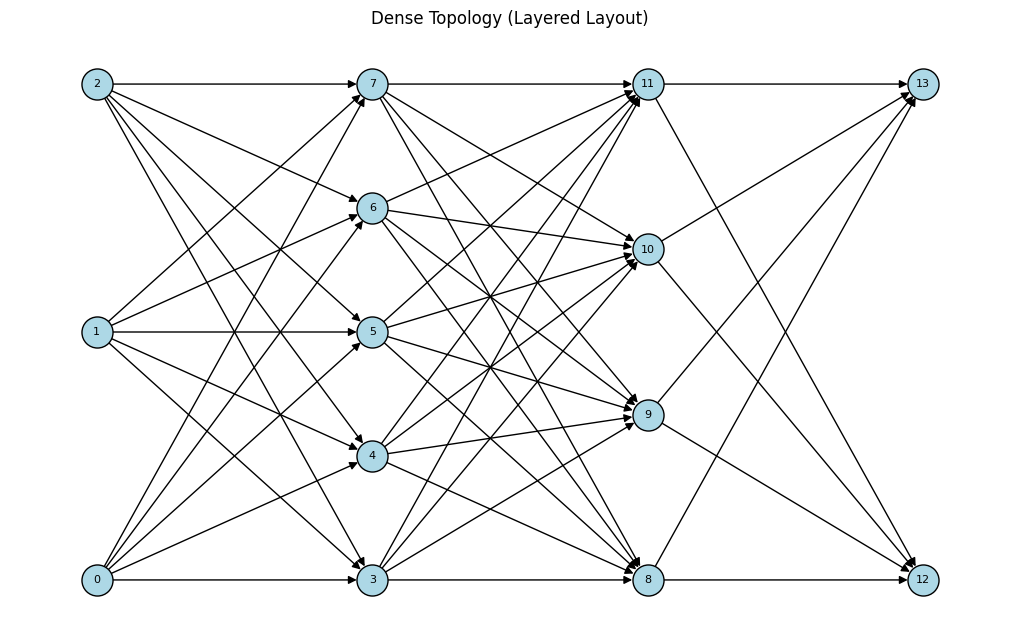

In [42]:

G, inputs, outputs = create_dense_topology(3, [5, 4], 2, seed=42)
visualize_dense_topology(G, 3, [5, 4], 2)

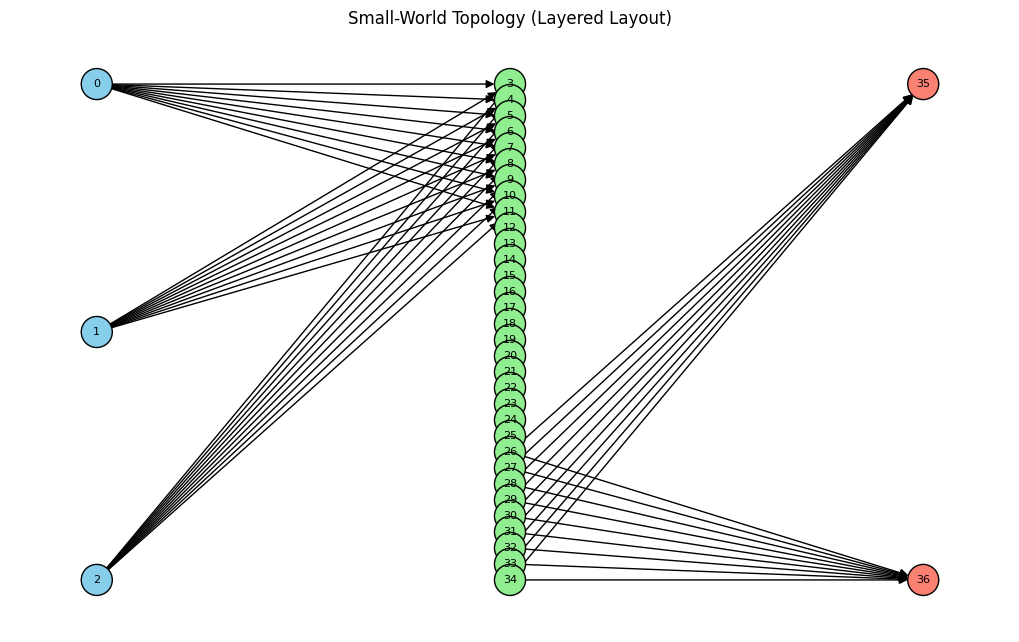

In [50]:
# Create topology
G, input_nodes, output_nodes = create_small_world_topology(
    input_dim=3, hidden_size=32, output_dim=2, k=9, p=0.2, seed=42
)

# Visualize it
visualize_small_world_topology(G, input_nodes, output_nodes)


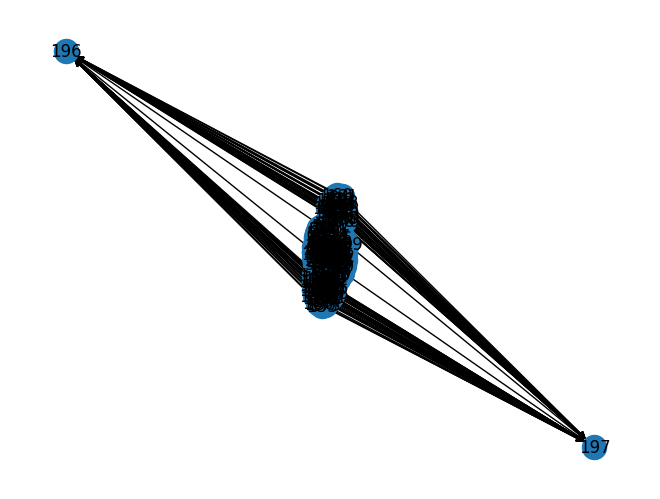

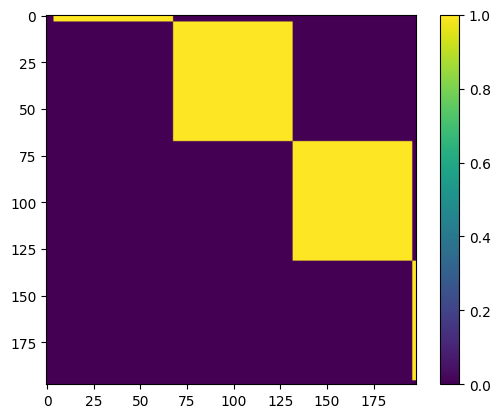

In [ ]:
# Create topology
dense_topology, dense_input_nodes, dense_output_nodes = create_dense_topology(
    input_dim, [hidden_size, hidden_size, hidden_size], output_dim, seed
)


# visualise the nx graph node by node
nx.draw(dense_topology, with_labels=True)
plt.show()

# output connecitivity matrix plot
plt.imshow(nx.to_numpy_array(dense_topology))
plt.colorbar()
plt.show()

In [45]:
# Create topology
small_world_topology, small_world_input_nodes, small_world_output_nodes = create_small_world_topology(
    input_dim=3, hidden_size=10, output_dim=2, k=4, p=0.3, seed=42
)

# Visualize it
visualize_small_world_topology(
    small_world_topology,
    small_world_input_nodes,
    small_world_output_nodes
)


TypeError: visualize_small_world_topology() missing 1 required positional argument: 'output_dim'

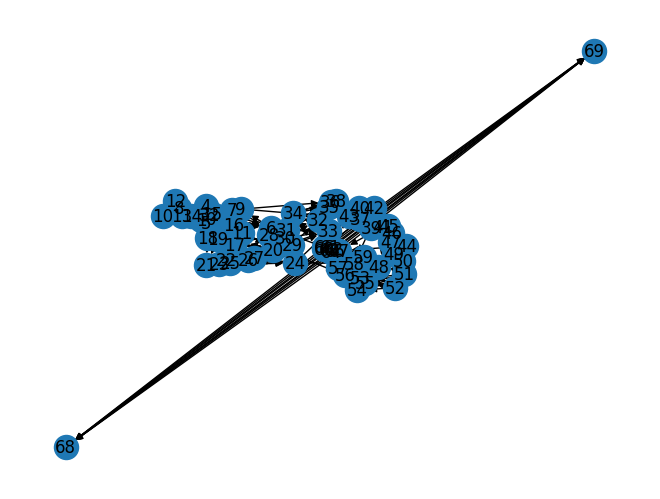

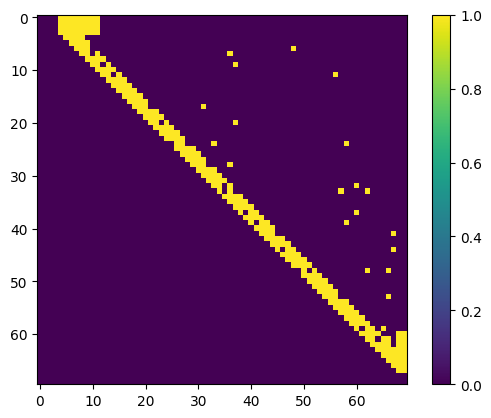

In [30]:
# Create topology
small_world_topology, small_world_input_nodes, small_world_output_nodes = create_small_world_topology(
    input_dim, hidden_size, output_dim, k, p, seed
)


# visualise the nx graph node by node
nx.draw(small_world_topology, with_labels=True)
plt.show()

# output connecitivity matrix plot
plt.imshow(nx.to_numpy_array(small_world_topology))
plt.colorbar()
plt.show()

In [11]:

# Create network
network = TopologyNetwork(topology, input_nodes, output_nodes, seed=seed)

# Create agent
agent = DQNAgent(network, learning_rate=learning_rate, gamma=gamma, device=device)

# Create replay buffer
replay_buffer = ExperienceReplayBuffer(capacity=replay_buffer_size)

# Training history
episode_rewards = []
episode_losses = []
epsilon = epsilon_start

# Weight/bias tracking for visualization
weight_history = []
bias_history = []
tracking_episodes = []

print(f"Starting DQN training on {env_name}")
print(f"Network topology: {len(topology.nodes())} nodes, {len(topology.edges())} edges")
print(f"Input dim: {input_dim}, Output dim: {output_dim}, Hidden size: {hidden_size}")
print(f"Tracking weights/biases every {track_freq} episodes")

for episode in range(num_episodes):
    state, _ = env.reset()
    episode_reward = 0
    episode_loss = 0
    num_train_steps = 0
    
    for step in range(max_steps_per_episode):
        # Select action
        action = agent.select_action(state, epsilon)
        
        # Take step
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        
        # Store transition
        replay_buffer.store(state, action, reward, next_state, done)
        
        # Train if buffer is large enough
        if len(replay_buffer) >= min_buffer_size:
            loss = agent.train_step(replay_buffer, batch_size)
            episode_loss += loss
            num_train_steps += 1
        
        state = next_state
        episode_reward += reward
        
        if done:
            break
    
    # Update target network periodically
    if episode % target_update_freq == 0:
        agent.update_target_network()
    
    # Decay epsilon
    epsilon = max(epsilon_end, epsilon * epsilon_decay)
    
    # Record history
    episode_rewards.append(episode_reward)
    if num_train_steps > 0:
        episode_losses.append(episode_loss / num_train_steps)
    else:
        episode_losses.append(0.0)
    
    # Track weights/biases at regular intervals
    if (episode + 1) % track_freq == 0 or episode == 0:
        weights, biases = agent.get_current_weights_biases()
        weight_history.append(weights.copy())
        bias_history.append(biases.copy())
        tracking_episodes.append(episode + 1)
    
    # Print progress
    if (episode + 1) % 50 == 0:
        avg_reward = np.mean(episode_rewards[-50:])
        avg_loss = np.mean(episode_losses[-50:]) if episode_losses else 0.0
        print(f"Episode {episode + 1}/{num_episodes} | "
                f"Avg Reward: {avg_reward:.2f} | "
                f"Avg Loss: {avg_loss:.4f} | "
                f"Epsilon: {epsilon:.3f}")

env.close()

Starting DQN training on CartPole-v1
Network topology: 70 nodes, 294 edges
Input dim: 4, Output dim: 2, Hidden size: 64
Tracking weights/biases every 10 episodes
Episode 50/500 | Avg Reward: 21.70 | Avg Loss: 0.0807 | Epsilon: 0.778


KeyboardInterrupt: 

In [ ]:
# print out results
print(f"Episode rewards: {episode_rewards}")
print(f"Episode losses: {episode_losses}")
print(f"Network: {agent.main_network}")
print(f"Topology: {topology}")
print(f"Input nodes: {input_nodes}")
print(f"Output nodes: {output_nodes}")
print(f"Weight history: {weight_history}")
print(f"Bias history: {bias_history}")
print(f"Tracking episodes: {tracking_episodes}")
